# Risk profiling for customer churn

In this project we download a dataset using the Kaggle Api, apply some data transformation, and use a linear regression model to calculate the churn risk of customers. 

In [1]:
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi
from pandas_profiling import ProfileReport

- Read in churn dataset, exploratory analysis (heat matrix of correlation)
- build a model - decision tree? to model and understand. 
                - What are the weights? - do we need multiple models? 
- predict risk, instead of categories, profile the customer based on that... no need to worry about low-risk (or praise)

In [2]:
# Use the Kaggle API to download the dataset
download = False

if download: 
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('shrutimechlearn/churn-modelling', path='kaggle_datasets', unzip=True)

In [3]:
df = pd.read_csv('kaggle_datasets/Churn_Modelling.csv')
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'])
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Let's have a look at the stats of the columns
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Prep data for modelling 

In [5]:
def get_int_col(in_df):
    in_df = in_df.reset_index()
    in_df['index'] = in_df['index'].astype(int)
    return in_df
    
def get_dummies(in_df, column):
    dum_df = pd.get_dummies(in_df[column])
    l1 = [i for i in dum_df.columns]
    l2 = ['%s_'%i+column for i in dum_df.columns]
    for i in range(0, len(l1)):
        dum_df = dum_df.rename(index=str,columns={l1[i]:l2[i]})
    dum_df = get_int_col(dum_df)     
    # Drop first column to avoid dummy trap
    dum_df = dum_df.drop(dum_df.columns[1], axis=1) 
    return dum_df

def merge_dfs(df1, df2, column):
    df1 = df1.merge(df2, left_on='index', right_on='index').set_index('index')
    df1 = df1.drop(columns=column)
    return df1

In [6]:
# Get dummy variables for categoric columns
geo_df = get_dummies(df, 'Geography')
num_prod_df = get_dummies(df, 'NumOfProducts')
cr_card_df = get_dummies(df, 'HasCrCard')
act_memb_df = get_dummies(df, 'IsActiveMember')

In [7]:
# Let's have a look at one of the examples
geo_df.sample(5)

,index,Germany_Geography,Spain_Geography
5093,5093,1,0
3011,3011,0,1
2474,2474,0,0
9243,9243,0,1
8338,8338,0,1


In [8]:
df = get_int_col(df)

# Merge the dummy dataframes back into the dataset
df = merge_dfs(df, geo_df, 'Geography')
df = merge_dfs(df, num_prod_df, 'NumOfProducts')
df = merge_dfs(df, cr_card_df, 'HasCrCard')
df = merge_dfs(df, act_memb_df, 'IsActiveMember')

df.head()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Germany_Geography,Spain_Geography,2_NumOfProducts,3_NumOfProducts,4_NumOfProducts,1_HasCrCard,1_IsActiveMember
index,,,,,,,,,,,,,
0,619,42,2,0.00,101348.88,1,0,0,0,0,0,1,1
1,608,41,1,83807.86,112542.58,0,0,1,0,0,0,0,1
2,502,42,8,159660.80,113931.57,1,0,0,0,1,0,1,0
3,699,39,1,0.00,93826.63,0,0,0,1,0,0,0,0
4,850,43,2,125510.82,79084.10,0,0,1,0,0,0,1,1


## Select X and y

The dataset is ready for modelling. We need to select independent and the dependent variable, applu feature scaling, and split the dataset into training and test set.

In [9]:
X = df.drop(columns=['Exited'])
y = df['Exited'].values

# Apply feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

## Fit logistic regression model

In [10]:
# Train a logistic regression model on the raining set
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state = 0)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Next, we apply k-fold cross validation to calculate the accuracy of the model.

In [11]:
# Apply k-Fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = X, y = y, cv = 10)
print('Accuracy:', accuracies.mean())
print('Standard deviation: ', accuracies.std())

Accuracy: 0.8408
Standard deviation:  0.007277362159464108


## Get the probabilities for plotting purposes

In [12]:
y_pred_proba = model.predict_proba(X)

Create probability dataframe and rename columns

In [13]:
proba_df = pd.DataFrame(y_pred_proba)
proba_df['y_test'] = y

In [14]:
proba_df = proba_df.rename(columns={0:'retention_proba', 1:'churn_proba'})

In [15]:
def risk_calc(row):
    if row['churn_proba']<0.2: 
        return "Low risk (<20%)"
    elif 0.2<=row['churn_proba']<=0.8: 
        return 'Medium risk (20%-80%)'
    else:
        return 'High risk (>80%)'

proba_df['risk_rating'] = proba_df.apply(risk_calc, axis=1)

In [16]:
proba_df.sample(10)

,retention_proba,churn_proba,y_test,risk_rating
8681,0.964179,0.035821,0,Low risk (<20%)
6011,0.629745,0.370255,1,Medium risk (20%-80%)
2370,0.733341,0.266659,0,Medium risk (20%-80%)
7209,0.581149,0.418851,1,Medium risk (20%-80%)
7521,0.612241,0.387759,0,Medium risk (20%-80%)
4130,0.690480,0.309520,0,Medium risk (20%-80%)
1516,0.735170,0.264830,0,Medium risk (20%-80%)
8899,0.962285,0.037715,0,Low risk (<20%)
102,0.840356,0.159644,0,Low risk (<20%)
2292,0.987228,0.012772,0,Low risk (<20%)


In [17]:
# Get the number of cases per risk category
grouped_proba_df = proba_df['risk_rating'].value_counts().reset_index()

In [54]:
proba_df['risk_rating'].value_counts().reset_index()['risk_rating']

0    6478
1    3231
2     291
Name: risk_rating, dtype: int64

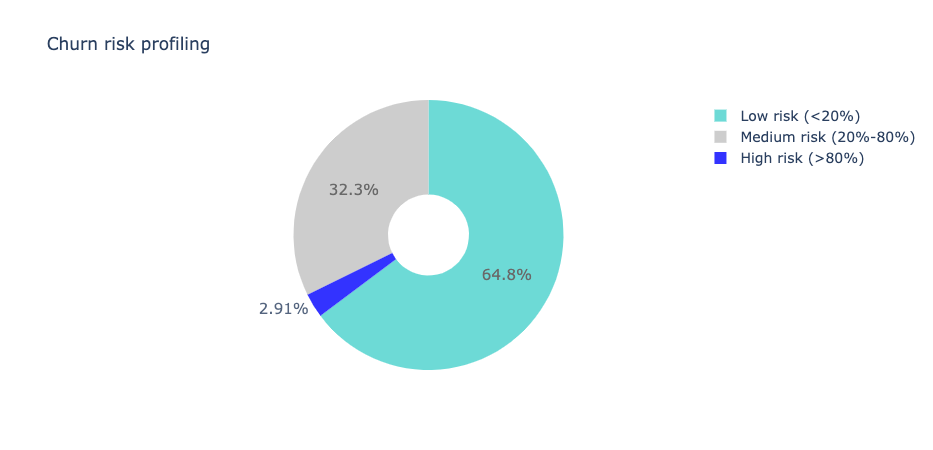

In [57]:
import plotly.graph_objects as go

colors = [ 'mediumturquoise', 'silver', 'blue'] 

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=proba_df['risk_rating'].value_counts().reset_index()['index'], 
                             values=proba_df['risk_rating'].value_counts().reset_index()['risk_rating'], 
                             textfont_size=15,
                             opacity=0.8,
                             marker_colors=colors, 
                             hole=.3)])


fig.update_layout(title_text='Churn risk profiling', 
                  template='plotly_white',
                  legend=dict(
                        font=dict(
                            size=14,
                        ),)
                  
                 )
fig.show()